###  프로젝트 개요

본 프로젝트는 Apple Inc. (AAPL)의 주가 데이터를 활용하여, 과거 주가 흐름 및 기술적 분석 지표를 바탕으로 **실적 발표 이후의 하락/상승장을 예측**하는 시계열 머신러닝 모델을 개발하는 것을 목표로 합니다.


###  문제 정의

애플(AAPL)의 실적 발표는 주가에 직접적인 영향을 미치는 주요 이벤트입니다. 하지만 시장 반응은 일정하지 않고 다양한 요인(기술적 흐름, 수급, 기대감 등)에 따라 달라지기 때문에, **실적 발표 이후 수익률을 사전에 예측하는 것은 어려운 문제**입니다.

본 프로젝트는 이를 해결하기 위해 다음과 같은 문제를 설정합니다:

- 실적 발표일을 기준으로 기술적 지표를 사용하여
  이후 주가 변화(상승/하락장)을 예측할 수 있는가?

###  프로젝트 목표

1. Yahoo Finance를 활용하여 애플의 주가 및 실적 발표 데이터 수집
2. 기술적 지표(RSI, ROC, MA, EMA 등) 기반 Feature Engineering
3. LSTM, XGBoost, LinearRegression 등 다양한 모델을 적용하여 예측
4. RMSE, R² 등의 성능지표 기반 평가 및 시각화
5. 성능이 우수한 모델을 `.h5` 파일로 저장 및 배포(Deploy) 고려

---

다음 셀에서는 데이터 로딩 및 전처리를 수행합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/ts_data

/content/drive/MyDrive/ts_data


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from deap import base, creator, tools, algorithms
import random

In [ ]:
# Data Collecting
# 1. Apple 주가 데이터 수집
aapl = yf.Ticker("AAPL")
df_price = aapl.history(start="2010-01-01", end="2025-01-01")
df_price = df_price.reset_index()
df_price["Date"] = pd.to_datetime(df_price["Date"])
df_price.set_index("Date", inplace=True)
df_price.index = df_price.index.tz_localize(None)

df_price.to_excel("/content/drive/MyDrive/ts_data/AAPL_price_2010_2025.xlsx")

In [ ]:
df_price = pd.read_excel("/content/drive/MyDrive/ts_data/AAPL_price_2010_2025.xlsx")

In [ ]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04,6.422875,6.455075,6.391277,6.440330,493729600,0.0,0
1,2010-01-05,6.458087,6.487880,6.417460,6.451467,601904800,0.0,0
2,2010-01-06,6.451466,6.477045,6.342226,6.348846,552160000,0.0,0
3,2010-01-07,6.372319,6.379843,6.291067,6.337110,477131200,0.0,0
4,2010-01-08,6.328684,6.379844,6.291369,6.379241,447610800,0.0,0


In [ ]:
# 2. 실적 발표 데이터: 엑셀 파일로 대체
df_earnings = pd.read_csv("/content/drive/MyDrive/ts_data/from10to25_AAPL_Earning_Data.csv")
df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"])
# 날짜 형식을 'YYYY-MM-DD' 문자열로 변환
df_earnings["Earnings Date"] = df_earnings["Earnings Date"].dt.date

df_earnings_save = df_earnings

print(" 주가 데이터:", df_price.shape)
print(" 실적 발표 데이터:", df_earnings.shape)

 주가 데이터: (3774, 8)
 실적 발표 데이터: (67, 13)


<ipython-input-7-3776e937aa0b>:3: FutureWarning: Parsed string "January 30, 2025 at 4 PM EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"])
<ipython-input-7-3776e937aa0b>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"])
<ipython-input-7-3776e937aa0b>:3: FutureWarning: Parsed string "October 31, 2024 at 4 PM EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to

In [ ]:
df_earnings.tail(10)

,Earnings Date,EPS Estimate,Reported EPS,Surprise (%),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
57,2010-10-18,0.15,0.17,13.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2010-07-20,0.11,0.13,12.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2010-04-20,0.09,0.12,36.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,2010-01-25,0.07,0.13,76.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_price.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [ ]:
df_earnings.isnull().sum()
#불필요한 칼럼 다수 및 결측지 확인

,0
Earnings Date,6
EPS Estimate,6
Reported EPS,6
Surprise (%),6
Unnamed: 4,67
Unnamed: 5,67
Unnamed: 6,67
Unnamed: 7,67
Unnamed: 8,67
Unnamed: 9,67


In [ ]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_roc(series, period=10):
    return (series - series.shift(period)) / series.shift(period) * 100

In [ ]:
# PreProcessing
# 1. 필요한 컬럼만 추출
cols_needed = ["Earnings Date", "Reported EPS", "EPS Estimate", "Surprise (%)"]
df_earnings = df_earnings[cols_needed].copy()

# 2. 실적 데이터 타입 및 인덱스 설정 (중복 제거 포함)
df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"], errors='coerce')
df_earnings = df_earnings.dropna(subset=["Earnings Date"])  # 날짜형 변환 실패 제거
df_earnings = df_earnings.drop_duplicates(subset="Earnings Date")
df_earnings = df_earnings.sort_values(by="Earnings Date").reset_index(drop=True)

In [ ]:
# 3. 실적 데이터 Up Sampling (일 단위로 확장, forward fill)
df_earnings.set_index("Earnings Date", inplace=True)
df_earnings = df_earnings.resample('D').ffill()

실적 발표 후 (a) 다음 실적 발표까지 (b) 의 기간동안 (a)의 값이 주가 데이터에 영향을 끼친다는 가정하에 코딩

In [ ]:
# 4. 주가 데이터 결측치 처리
# 기본적으로 forward fill 적용 후 남은 결측치는 선형 보간으로 보완
if df_price.isna().sum().sum() > 0:
    df_price.ffill(inplace=True)
    if df_price.isna().sum().sum() > 0:
        df_price.interpolate(method='linear', inplace=True)

In [ ]:
# 5. 지수 평활화(Exponential Smoothing) 적용
alpha = 0.2
df_price["Close_smooth"] = df_price["Close"].ewm(alpha=alpha).mean()
df_price["Volume_smooth"] = df_price["Volume"].ewm(alpha=alpha).mean()

In [ ]:
# 6. 기술 지표 계산용 함수 정의 및 적용

df_price["RSI_smooth"] = compute_rsi(df_price["Close_smooth"])
df_price["ROC_smooth"] = compute_roc(df_price["Close_smooth"])

# 7. 기술 지표 계산 후 생길 수 있는 NaN 제거 및 소수점 반올림
df_price.dropna(inplace=True)
df_price = df_price.round(2)

In [ ]:
# 8. 실적 이상치 제거 (Surprise % 기준)
df_earnings = df_earnings[df_earnings["Surprise (%)"].between(-100, 100)]

# 9. 정렬 및 확인
df_price.sort_index(inplace=True)
df_earnings.sort_index(inplace=True)

# 10. 상태 확인 출력
print(" df_price 결측치:", df_price.isna().sum().sum())
print(" df_earnings 결측치:", df_earnings.isna().sum().sum())

 df_price 결측치: 0
 df_earnings 결측치: 0


In [ ]:
df_earnings.head()

,Reported EPS,EPS Estimate,Surprise (%)
Earnings Date,,,
2010-01-25,0.13,0.07,76.0
2010-01-26,0.13,0.07,76.0
2010-01-27,0.13,0.07,76.0
2010-01-28,0.13,0.07,76.0
2010-01-29,0.13,0.07,76.0


In [ ]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_smooth,Volume_smooth,RSI_smooth,ROC_smooth
13,2010-01-22,6.22,6.24,5.93,5.95,881767600,0.0,0,6.25,6.500507e+08,17.51,-2.11
14,2010-01-25,6.09,6.16,6.02,6.11,1065699600,0.0,0,6.22,7.362120e+08,15.97,-2.54
15,2010-01-26,6.20,6.43,6.10,6.20,1867110000,0.0,0,6.22,9.689424e+08,14.13,-2.37
16,2010-01-27,6.22,6.34,6.00,6.26,1722568400,0.0,0,6.22,1.123140e+09,18.52,-1.79
17,2010-01-28,6.17,6.18,5.98,6.00,1173502400,0.0,0,6.18,1.133397e+09,17.19,-2.52


In [ ]:
#EDA
print(df_price.describe())

                                Date         Open         High          Low  \
count                           3761  3761.000000  3761.000000  3761.000000   
mean   2017-07-11 08:00:53.602765056    67.676732    68.389606    67.006421   
min              2010-01-22 00:00:00     5.790000     5.900000     5.730000   
25%              2013-10-16 00:00:00    17.600000    17.730000    17.410000   
50%              2017-07-12 00:00:00    35.670000    35.920000    35.330000   
75%              2021-04-07 00:00:00   126.810000   128.460000   125.450000   
max              2024-12-31 00:00:00   257.910000   259.810000   257.350000   
std                              NaN    65.538301    66.226851    64.918418   

             Close        Volume    Dividends  Stock Splits  Close_smooth  \
count  3761.000000  3.761000e+03  3761.000000   3761.000000   3761.000000   
mean     67.733289  2.287971e+08     0.002313      0.002925     67.471234   
min       5.780000  2.323470e+07     0.000000      0.0000

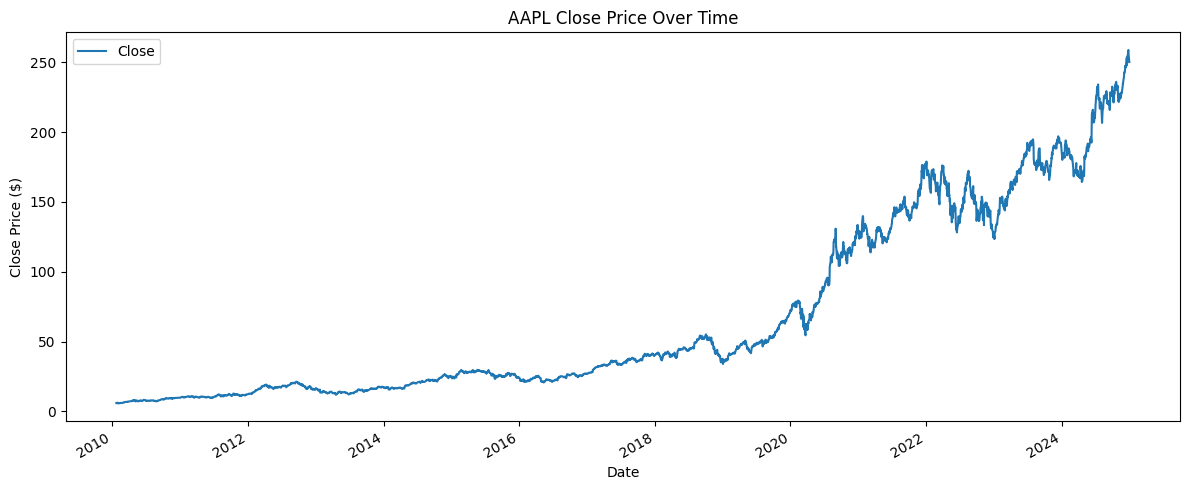

In [ ]:
# 종가 추세
df_price.reset_index().plot(x="Date", y="Close", figsize=(12, 5), title="AAPL Close Price Over Time")
plt.ylabel("Close Price ($)")
plt.tight_layout()
plt.show()

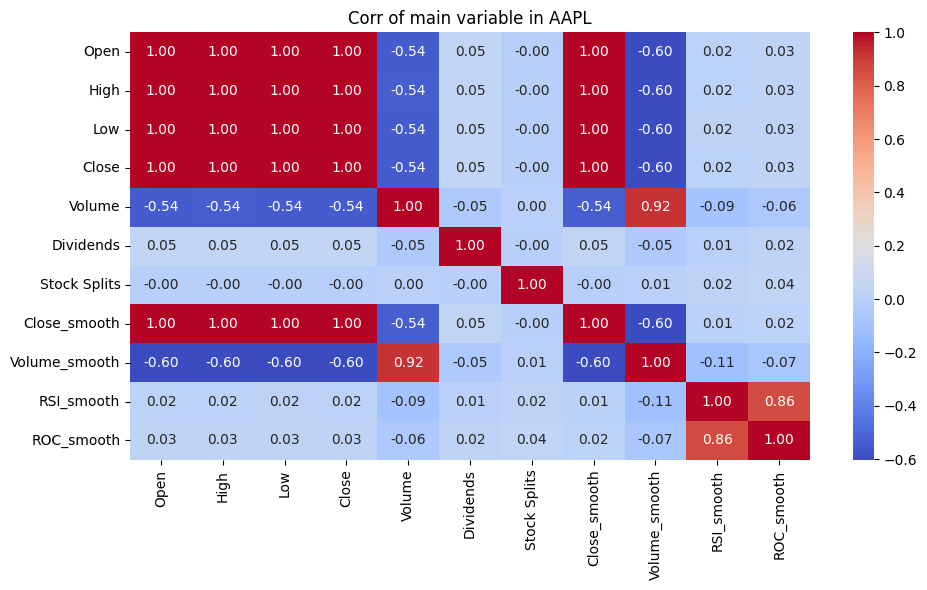

In [ ]:
# 상관관계 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(df_price.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corr of main variable in AAPL")
plt.tight_layout()
plt.show()

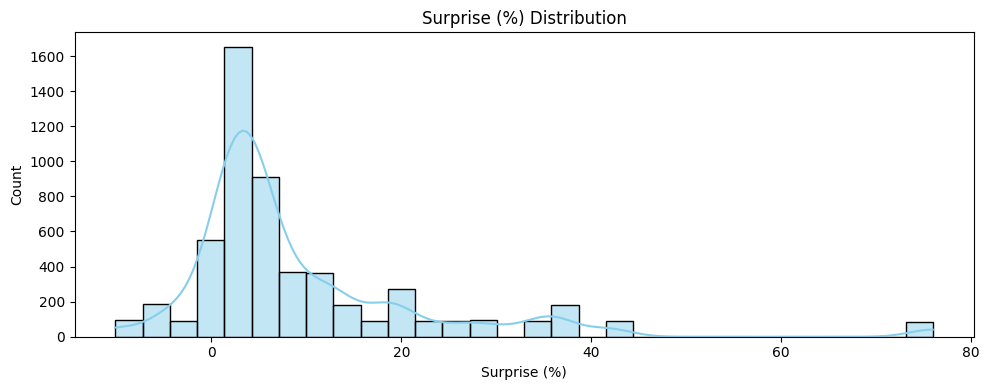

In [ ]:
# Surprise (%) 분포
plt.figure(figsize=(10, 4))
sns.histplot(df_earnings["Surprise (%)"], bins=30, kde=True, color="skyblue")
plt.title("Surprise (%) Distribution")
plt.xlabel("Surprise (%)")
plt.tight_layout()
plt.show()

1. 종가 추세:
   - 2010~2025 기간 동안 AAPL 종가는 전반적으로 상승하는 추세를 보입니다.
   - 특히 2020 이후 큰 폭의 상승과 변동성이 관측됩니다.

2.  상관관계 히트맵:
   - Close, Close_smooth, RSI_smooth, ROC_smooth 간에 높은 상관성이 관찰됩니다.
   - Volume_smooth는 가격 계열과 비교적 낮은 상관을 보이며 독립 Feature로 활용 가능성이 있습니다.

3. Surprise (%) 분포:
   - 대체로 +10% ~ +20% 사이가 가장 많으며, 전반적으로 양(+)의 Surprise가 많습니다.
   - 이는 실적 발표가 시장 예상치를 상회하는 경우가 많음을 뜻합니다.

In [ ]:
#Feature Engineering(TA 지표들)
# 기본 이동 평균선
for window in [5, 10, 20]:
    df_price[f"MA_{window}"] = df_price["Close"].rolling(window=window).mean()

# GDC: Golden Cross / Dead Cross (MA_5 vs MA_20)
df_price['GDC'] = 0
cross_up = (df_price['MA_5'] > df_price['MA_20']) & (df_price['MA_5'].shift(1) <= df_price['MA_20'].shift(1))
cross_down = (df_price['MA_5'] < df_price['MA_20']) & (df_price['MA_5'].shift(1) >= df_price['MA_20'].shift(1))
df_price.loc[cross_up, 'GDC'] = 1  # Golden Cross
df_price.loc[cross_down, 'GDC'] = -1  # Dead Cross

# Stochastic Oscillator (%K, %D)
df_price['Low14'] = df_price['Low'].rolling(window=14).min()
df_price['High14'] = df_price['High'].rolling(window=14).max()
df_price['%K'] = (df_price['Close'] - df_price['Low14']) / (df_price['High14'] - df_price['Low14']) * 100
df_price['%D'] = df_price['%K'].rolling(window=3).mean()

# MACD (12,26 EMA and Signal)
df_price['EMA12'] = df_price['Close'].ewm(span=12, adjust=False).mean()
df_price['EMA26'] = df_price['Close'].ewm(span=26, adjust=False).mean()
df_price['MACD'] = df_price['EMA12'] - df_price['EMA26']
df_price['Signal'] = df_price['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20-day SMA ± 2 std)
df_price['MA20'] = df_price['Close'].rolling(window=20).mean()
df_price['BB_upper'] = df_price['MA20'] + 2 * df_price['Close'].rolling(window=20).std()
df_price['BB_lower'] = df_price['MA20'] - 2 * df_price['Close'].rolling(window=20).std()

# Volume Change %
df_price['Volume_change'] = df_price['Volume'].pct_change() * 100

# 기타 기본 지표
df_price["RSI_smooth"] = compute_rsi(df_price["Close_smooth"])
df_price["ROC_smooth"] = compute_roc(df_price["Close_smooth"])

df_price.dropna(inplace=True)
df_price = df_price.round(2)

df_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3742 entries, 32 to 3773
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3742 non-null   datetime64[ns]
 1   Open           3742 non-null   float64       
 2   High           3742 non-null   float64       
 3   Low            3742 non-null   float64       
 4   Close          3742 non-null   float64       
 5   Volume         3742 non-null   int64         
 6   Dividends      3742 non-null   float64       
 7   Stock Splits   3742 non-null   int64         
 8   Close_smooth   3742 non-null   float64       
 9   Volume_smooth  3742 non-null   float64       
 10  RSI_smooth     3742 non-null   float64       
 11  ROC_smooth     3742 non-null   float64       
 12  MA_5           3742 non-null   float64       
 13  MA_10          3742 non-null   float64       
 14  MA_20          3742 non-null   float64       
 15  GDC            3742 non-n

## Feature Engineering: 기술적 지표 설명
### 1. 이동 평균선 (Moving Averages)
MA_5, MA_10, MA_20

  *  최근 5일, 10일, 20일 동안의 종가 평균을 계산한 단순 이동 평균선 (SMA).


###2. GDC (Golden Cross / Dead Cross)
* 1: 골든 크로스 (단기 이동평균선 MA_5가 장기 MA_20을 상향 돌파)

* -1: 데드 크로스 (단기 이동평균선 MA_5가 장기 MA_20을 하향 돌파)

* 0: 변화 없음


###3. Stochastic Oscillator (%K, %D)

1. Low14, High14: 최근 14일간의 최저가 및 최고가

2. %K: 현재 종가가 14일 고저 범위 내에서 어디쯤 위치하는지를 나타냄
(%K = (Close - Low14) / (High14 - Low14) * 100)

3. %D: %K의 3일 단순 이동 평균. %K에 비해 더 부드러운 신호선으로 사용됨.

* **과매수/과매도 판단 기준: 일반적으로 %K 또는 %D가 80 이상이면 과매수, 20 이하면 과매도 가능성.**

### 4. MACD (Moving Average Convergence Divergence)

1. EMA12: 12일 지수 이동 평균

2. EMA26: 26일 지수 이동 평균

3. MACD: EMA12 - EMA26, 단기 추세와 장기 추세 간의 차이

4. Signal: MACD의 9일 지수 이동 평균으로, 신호선 역할을 함

* **MACD > Signal은 매수, < Signal은 매도 신호로 해석될 수 있음.**

### 5. Bollinger Bands

1. MA20: 20일 단순 이동 평균 (기준선)

2. BB_upper: MA20 + 2 * 표준편차, 상단 밴드

3. BB_lower: MA20 - 2 * 표준편차, 하단 밴드

* **주가가 상단 밴드를 돌파하면 과매수, 하단 밴드 돌파 시 과매도 상태일 수 있음.**

### 6. Volume Change (%)
* Volume_change: 전일 대비 거래량의 변화율 (%)




In [ ]:
df_price = df_price.copy()
df_price.reset_index(inplace=True)


df_earnings = df_earnings.copy()
df_earnings.reset_index(inplace=True)
df_earnings.rename(columns={"Earnings Date": "Date"}, inplace=True)

df_price.sort_values("Date", inplace=True)
df_earnings.sort_values("Date", inplace=True)

#df_earnings와 df_price 병합
df_merged = pd.merge_asof(df_price, df_earnings, on="Date", direction="backward")

# 다시 날짜 인덱스 설정
df_merged.set_index("Date", inplace=True)

# 확인
print(" 병합 후 shape:", df_merged.shape)
df_merged.head()


 병합 후 shape: (3742, 31)


,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_smooth,Volume_smooth,...,EMA26,MACD,Signal,MA20,BB_upper,BB_lower,Volume_change,Reported EPS,EPS Estimate,Surprise (%)
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-19,32,6.07,6.12,6.05,6.07,415469600,0.0,0,6.03,5.320239e+08,...,5.99,0.03,0.01,5.99,6.26,5.71,-1.74,0.13,0.07,76.0
2010-02-22,33,6.09,6.09,5.99,6.03,390563600,0.0,0,6.03,5.037175e+08,...,5.99,0.03,0.01,5.99,6.26,5.72,-5.99,0.13,0.07,76.0
2010-02-23,34,6.02,6.06,5.89,5.93,575094800,0.0,0,6.01,5.179988e+08,...,5.98,0.02,0.01,5.98,6.25,5.71,47.25,0.13,0.07,76.0
2010-02-24,35,5.97,6.06,5.95,6.04,460566400,0.0,0,6.02,5.065086e+08,...,5.99,0.02,0.01,5.97,6.22,5.72,-19.91,0.13,0.07,76.0
2010-02-25,36,5.94,6.10,5.93,6.08,665126000,0.0,0,6.03,5.382403e+08,...,6.00,0.02,0.02,5.96,6.18,5.75,44.41,0.13,0.07,76.0


In [ ]:
#Data Spliting
# 1. 학습 / 검증 / 테스트 분할 기준 설정
train_end = "2022-12-31"
val_end = "2023-12-31"

# 2. 타겟 변수 정의
df_merged["target_return_3d"] = df_merged["Close"].shift(-3)
df_merged["target_return_3d"] = (df_merged["target_return_3d"] - df_merged["Close"]) / df_merged["Close"] * 100
df_merged["target_direction"] = (df_merged["target_return_3d"] > 0).astype(int)

# 3. Feature 선택
features = [
    "Close", "Volume", "MA_5", "MA_10", "MA_20", "GDC", "%K", "%D",
    "MACD", "Signal", "BB_upper", "BB_lower", "Volume_change",
    "RSI_smooth", "ROC_smooth", "Surprise (%)"
]

df_filtered = df_merged.dropna(subset=features + ["target_return_3d"])  # 결측치 제거
X = df_filtered[features]
y = df_filtered["target_return_3d"]

# 4. 시계열 분할
X_train = X[X.index <= train_end]
X_val = X[(X.index > train_end) & (X.index <= val_end)]
X_test = X[X.index > val_end]

y_train = y[X.index <= train_end]
y_val = y[(X.index > train_end) & (X.index <= val_end)]
y_test = y[X.index > val_end]

# 5. 결과 확인
print(" X_train:", X_train.shape)
print(" X_val:", X_val.shape)
print(" X_test:", X_test.shape)


 X_train: (3240, 16)
 X_val: (250, 16)
 X_test: (249, 16)


### 베이스라인 모델 선택 = XGBoost
다양한 TA와 실적 지표들을 피쳐로 활용하면서 빠른 학습 속도로 실험 가능하여 선택

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# 1. 타겟 수익률 기준 완화 및 이진 분류
threshold = 0.3  # 기존 0.5% → 0.3%로 완화하여 민감도 향상
y_train_bin = (y_train > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

# 2. 클래스 불균형 대응
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin)
scale_pos_weight = class_weights[0] / class_weights[1]

# 3. XGBoost 분류 모델 설정
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',  # 학습 속도 향상 옵션
    verbosity=0
)

# 4. 하이퍼파라미터 탐색 공간 축소 (실행 속도 향상)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05]
}

# 5. GridSearchCV
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 6. 모델 학습
grid.fit(X_train, y_train_bin)

# 7. 평가
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred)
conf_matrix = confusion_matrix(y_test_bin, y_pred)

# 8. 출력
print("최적 파라미터:", grid.best_params_)
print("CV 평균 F1 Score:", round(grid.best_score_, 4))
print("테스트 정확도:", round(acc, 4))
print("테스트 F1 Score:", round(f1, 4))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_bin, y_pred))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
CV 평균 F1 Score: 0.6672
테스트 정확도: 0.4779
테스트 F1 Score: 0.058
Confusion Matrix:
 [[115   1]
 [129   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.99      0.64       116
           1       0.80      0.03      0.06       133

    accuracy                           0.48       249
   macro avg       0.64      0.51      0.35       249
weighted avg       0.65      0.48      0.33       249



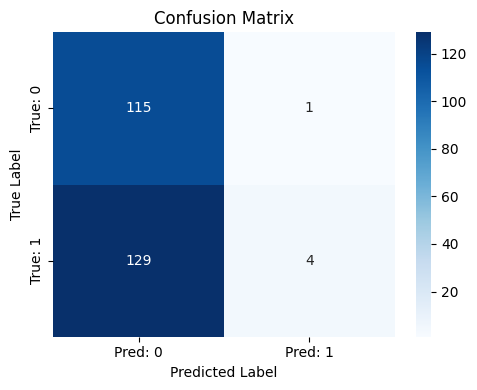

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bin, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### 1을 0으로 예측하는 과소적합(Under-prediction) 다소 발생

상승장 예측을 실질적으로 하지 못하고 있음

예상 해결법
1. 가중치 추가 조정
2. 임계값 threshold을 좀 더 작은 기준(0.5 -> 0.3 or 0.2로)으로 재정의
3. LSTM 등으로 모델 확장

* 1,2를 실행해봤으나 개선이 별로 이루어지지 않아 3번 실행

In [ ]:
# 1. 설치
!pip install keras-tuner --quiet

# 2. 패키지 임포트
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

# 3. 시퀀스 생성 함수
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

# 4. 데이터 정규화 및 시퀀스 변환
window_size = 10
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_bin.values, window_size)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_bin.values, window_size)

# 5. 하이퍼모델 정의
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units_1", min_value=64, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int("units_2", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int("units_3", min_value=16, max_value=64, step=16)
    ))
    model.add(Dropout(hp.Float("dropout_3", 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 6. 튜너 정의
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tune_dir",
    project_name="aapl_lstm"
)

# 7. 튜닝 수행
tuner.search(X_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

# 8. 최적 모델 선택 및 학습
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train_lstm, y_train_lstm, epochs=3, validation_split=0.2, batch_size=32)

# 9. 예측 및 평가
y_pred_prob = model.predict(X_test_lstm)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test_lstm, y_pred_class))
print("Classification Report:\n", classification_report(y_test_lstm, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_lstm, y_pred_class))


Trial 10 Complete [00h 03m 45s]
val_accuracy: 0.5820433497428894

Best val_accuracy So Far: 0.5835913419723511
Total elapsed time: 00h 26m 02s
Epoch 1/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5005 - loss: 0.6953 - val_accuracy: 0.5573 - val_loss: 0.6889
Epoch 2/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5141 - loss: 0.6910 - val_accuracy: 0.5325 - val_loss: 0.6880
Epoch 3/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5273 - loss: 0.6893 - val_accuracy: 0.5635 - val_loss: 0.6885
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5271966527196653
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.29      0.37       112
           1       0.54      0.73      0.62       127

    accuracy                           0.53       239
   macro avg       0.52      0.51      0.50       239
weighted avg       0.52      0.53      0.50       239

Confusion Matrix:
 [[33 79]
 [34 93]]


### 차후 개선점
1. 모델 성능이 너무 나오지 않고 있음

* 예상 원인
  1. 학습에 사용된 2022년 이전 데이터가 대부분 큰 변동 없이 낮은 주가 데이터를 보유
  2. 실적 데이터의 날짜를 Up Sampling 하는 방식 혹은 모델 빌딩에서의 잘못

2. TA 파라미터 GA 알고리즘을 통해 최적화 해보기

In [ ]:
#Deploy (비록 지금은 두 모델의 정확도가 모두 낮지만, LSTM 모델의 성능이 더 높다고 가정)
# 10. 실전 배포용 함수 정의
def predict_next_direction(model, latest_X_scaled, window_size=10):
    """
    최근 window_size만큼의 데이터를 입력으로 받아 상승(1)/하락(0)을 예측.
    latest_X_scaled: 정규화된 최근 입력 데이터 (shape: [window_size, num_features])
    """
    input_seq = np.expand_dims(latest_X_scaled[-window_size:], axis=0)  # (1, window, features)
    prob = model.predict(input_seq)[0][0]
    pred_class = int(prob > 0.5)
    direction = "상승" if pred_class == 1 else "하락"
    print(f"예측 확률: {prob:.4f} → 예측 결과: {direction}")
    return pred_class, prob


In [ ]:
 # 실전 예측 예시: 테스트 데이터 마지막 10개를 이용
recent_input = X_test_scaled[-window_size:]  # shape: (10, feature)
predict_next_direction(model, recent_input, window_size=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
예측 확률: 0.5147 → 예측 결과: 상승


(1, np.float32(0.51472056))

In [ ]:
# 모델 저장
model.save("lstm_aapl_model.h5")

# 이후 배포 환경에서 사용 시
# from tensorflow.keras.models import load_model
# loaded_model = load_model("lstm_aapl_model.h5")
# predict_next_direction(loaded_model, recent_input, window_size=10)

In [ ]:
#앞으로 해볼 것들

# 최적화: DEAP로 RSI, MACD, BB 파라미터 튜닝

# 평가 함수 정의
def evaluate(ind):
    rsi_p, ema_s, ema_l, bb_w = map(int, ind)
    temp = df_price.copy()
    temp['RSI_GA'] = compute_rsi(temp['Close'], period=rsi_p)
    temp['EMA_S'] = temp['Close'].ewm(span=ema_s).mean()
    temp['EMA_L'] = temp['Close'].ewm(span=ema_l).mean()
    temp['MACD_GA'] = temp['EMA_S'] - temp['EMA_L']
    temp['BB_upper_GA'] = temp['Close'].rolling(window=bb_w).mean() + 2 * temp['Close'].rolling(window=bb_w).std()
    temp.dropna(inplace=True)
    return (-temp['MACD_GA'].std(),)

# DEAP 설정
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("rsi", random.randint, 5, 30) #단기(5), 중기(14), 장기(30) 사이
toolbox.register("ema_s", random.randint, 5, 15) #단기 EMA는 일반적으로 12
toolbox.register("ema_l", random.randint, 20, 40) #장기 EMA는 26 정도
toolbox.register("bb", random.randint, 10, 30) #BB의 경우 20일이 평균 기준
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.rsi, toolbox.ema_s, toolbox.ema_l, toolbox.bb), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[5,5,20,10], up=[30,15,40,30], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=30, verbose=False)
best = tools.selBest(pop, 1)[0]
print(" 최적화된 파라미터 (RSI, EMA_short, EMA_long, BB_window):", best)

 최적화된 파라미터 (RSI, EMA_short, EMA_long, BB_window): [9, 15, 20, 11]
